# Design Optimization: HW5

## Seyed Yousef Soltanian 
 ### you can find the file at https://github.com/YousefSoltanian/MAE598_Design_Optimization.git

### Problem 1:

For this problem, we have to minimize the following cost function:

$$
Minimize_{A12,A21}: \
L = \sum_{x_1=x_{1i}} (p{^*}_i - p_i(x))^2
$$
where:
$$
p_i(x) = x_1exp(A_{12}(\frac{A_{21}(1-x_1)}{A_{12}x_1+A_{21}(1-x_1)})^2)p^{sat}_{1} + (1-x_1)exp(A_{21}(\frac{A_{12}x_1}{A_{12}x_1+A_{21}(1-x_1)})^2)p^{sat}_{2}
$$

And $x_{1i}$ , $p{^*}_i$ are the given values in the table.

And $p^{sat}_{1}$ , $p^{sat}_{1}$ can be found from Antoine equation. we are going to implemet a gradient descent algorithm to estimate the best values for $A_{21}$ , $A_{12}$ using the given data in the table. We used Pytorch for calculating the gradients.

In [10]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np


def equation(x, A12, A21, P_sat1, P_sat2):
    x2 = 1 - x
    term1 = A12 * (A21 * x2 / (A12 * x + A21 * x2))**2
    term2 = A21 * (A12 * x / (A12 * x + A21 * x2))**2
    return x * torch.exp(term1) * P_sat1 + x2 * torch.exp(term2) * P_sat2

# Gradient descent using PyTorch
def gradient_descent(x, P_data, initial_params, P_sat1, P_sat2, learning_rate, num_iterations):
    params = Variable(torch.tensor(initial_params), requires_grad=True)
    
    for _ in range(num_iterations):
        predictions = equation(x, params[0], params[1], P_sat1, P_sat2)
        loss = F.mse_loss(predictions, P_data)

        # Use autograd to compute the gradients
        loss.backward()

        # Update parameters
        with torch.no_grad():
            params -= learning_rate * params.grad

        # Clear the gradients
        params.grad.zero_()

    return params.data.numpy()



x1_data = torch.tensor([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])  
P_data = torch.tensor([28.1, 34.4, 36.7, 36.9, 36.8, 36.7, 36.5, 35.4, 32.9, 27.7, 17.5]) 

# Known saturation pressures
P_sat1 = 10**(8.07131 - (1730.63/(20+233.426)))
P_sat2 = 10**(7.43155  - (1554.679/(20+240.337)))

# Initial parameter guesses
initial_params = torch.tensor([0.1, 0.1])

# Hyperparameters
learning_rate = 1e-4
num_iterations = 10000

# Perform gradient descent
estimated_params = gradient_descent(x1_data, P_data, initial_params, P_sat1, P_sat2, learning_rate, num_iterations)

# Print the results
print(f"Estimated A12: {estimated_params[0]}")
print(f"Estimated A21: {estimated_params[1]}")


C:\Users\ssoltan2\AppData\Local\Temp\ipykernel_19452\2212734937.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = Variable(torch.tensor(initial_params), requires_grad=True)


Estimated A12: 1.9583526849746704
Estimated A21: 1.6892415285110474


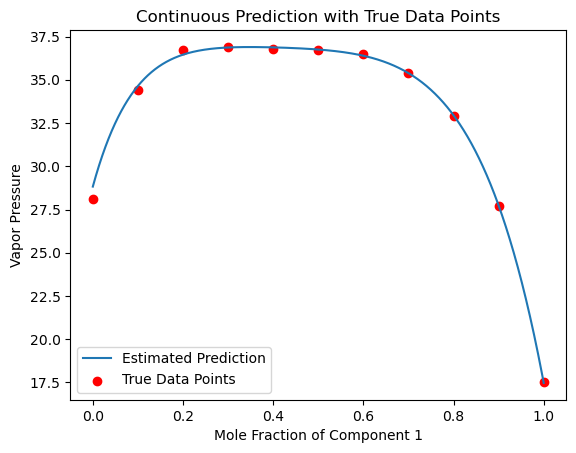

In [13]:
import matplotlib.pyplot as plt
x_continuous = np.linspace(0, 1, 2000)
x_continuous = torch.tensor(x_continuous)
P_continuous = equation(x_continuous, *estimated_params, P_sat1, P_sat2)
plt.plot(x_continuous, P_continuous, label='Estimated Prediction')
plt.scatter(x1_data, P_data, color='red', label='True Data Points')
plt.xlabel('Mole Fraction of Component 1')
plt.ylabel('Vapor Pressure')
plt.legend()
plt.title('Continuous Prediction with True Data Points')
plt.show()

### Problem 2:

We use the following package wich uses gaussian proccess

In [14]:
pip install bayesian-optimization

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [24]:
from bayes_opt import BayesianOptimization


def target_function(x1, x2):
    return -((4 - 2.1*(x1**2) + (x1**4)/3)*(x1**2) + x1*x2 + (-4 + 4*(x2**2))*(x2**2))


optimizer = BayesianOptimization(
    f=target_function,
    pbounds={'x1': (-3, 3), 'x2': (-2, 2)},  
    random_state=42, 
)

# Perform the optimization without printing each iteration
optimizer.maximize(init_points=0, n_iter=30)

# Print the result
print("Optimal parameters:", optimizer.max['params'])
print("Optimal value:", -optimizer.max['target'])


|   iter    |  target   |    x1     |    x2     |
-------------------------------------------------
| 1         | -29.55    | -0.7528   | 1.803     |
| 2         | -146.4    | 2.989     | -1.986    |
| 3         | -35.02    | -0.8206   | 1.868     |
| 4         | -11.48    | 0.8157    | 1.428     |
| 5         | -1.144    | -0.5973   | -0.1967   |
| 6         | -87.22    | -2.832    | -1.558    |
| 7         | -162.9    | 3.0       | 2.0       |
| 8         | -1.223    | 0.6067    | 0.04412   |
| 9         | -48.48    | -0.1764   | -2.0      |
| 10        | 1.024     | -0.04625  | 0.7069    |
| 11        | -105.7    | -3.0      | 0.9514    |
| 12        | 1.015     | 0.1029    | -0.6683   |
| 13        | -48.7     | 0.239     | 2.0       |
| 14        | -0.5645   | -1.109    | 0.7217    |
| 15        | -2.193    | 1.525     | 0.4264    |
| 16        | -0.5484   | 1.186     | -0.8228   |
| 17        | -2.726    | -1.21     | -0.8718   |
| 18        | -2.243    | -1.557    | -0.1339   |


### Problem 3:

I wasn't able to install Ansys on my ASU laptop due to the restrictions and regulations that they have for these kind of properties, but I am trying to naswer all the questions by considering "ANSYS DOE and Design Optimization Tutorial" as the optimization problem (Modal Analysis) for this problem.

more specifically from **"A. Durgude, A. Vipradas, S. Kishore, and S. Nimse (see their MAE598 Design Optimization project report (2016))."**
I tried to read their report very carefully and completely and answer the following questions based on their work as I myself wans't able to run the optimization problem, hoping that I can atleast get a portion of the total score for this problem.

**What are your design variables, constraints, and objectives?**

Design variables: The brake disc inner radius (P1), outer radius (P2) and thickness (P3)

Objectives: Free modal analysis is performed to ensure that the disc’s first natural frequency is higher
than the engine firing frequency. This guarantees that the disc does not experience failure due
to resonance, which is equal to maximizing the function below:


\begin{equation}
\text{Maximize: } F = \sum_{n=1}^{3} \gamma_n x_n + \sum_{n=4}^{6} \gamma_n x_n^2 + \gamma_7 \left(R^2 \text{ frequency} = 0.92\right)
\end{equation}

if we also wnat to minimize the volume of the disck, we have to consider minimization of the function below:

\begin{equation}
\text{Minimize: } f_1 : V = \sum_{n=1}^{3} \alpha_n x_n + \sum_{n=4}^{6} \alpha_n x_n^2 + \alpha_7 \left(R^2 \text{ volume} = 0.98\right)
\end{equation}

in the above functions $\gamma_n$s are the regression coeficcients for frequency and $\alpha_n$s are the regression coeficcients for vlolume and $x_n$s are our design variables. we ahve used second order polynomials to estimate the frequency and the volume.

Constraints: 

geometrical constraints: 


\begin{align*}
g_1 & : -P_1 \leq -66 \\
g_2 & : P_1 \leq 90 \\
g_3 & : -P_2 \leq -124 \\
g_4 & : P_2 \leq 150 \\
g_5 & : -P_3 \leq -5 \\
g_6 & : P_3 \leq 27 \\
\end{align*}



frequency constraint: 

\begin{align*}
g_8 : -F \leq -1200 \, \text{Hz}
\end{align*}


The final optimization problem for modal analysis will be the following multi-objective problem:
\[
\begin{align*}
\text{Minimize:} \quad & f_1, -f_3 \\
\text{Subject to:} \quad & g_1, g_2, g_3, g_4, g_5, g_6, g_8
\end{align*}
\]


**What design of experiment method do you use?**

Diifferent 50 numbers of simulation were done to generate the response surface, different design variables were tested in simulations for having enough data to slove the regeression problem (50 DOE points). Latin Hypercube Sampling (LHS) technique with user
defined sample points is used to create the response surface.

**What response surface method do you use?**

A second order polynomila was used using the least squar method and fitting with all 50 data points. 

**How do you validate your response surface?**

To validate the response surface, we have to check how good is the fitting, this can be done using R square of the fitting. as you can see in the answer of the first question, for volume fitting we have $(R^2\text{volume} = 0.98)$ and for the frequency response surface we have: $(R^2\text{frequency} = 0.92)$

**What optimization method do you use?**

The first natural frequency's lower bound constraint is parameterized, and the optimal volume related to these parameters is computed through the Interior Point Method (IPM) in MATLAB. Subsequently, a Pareto curve illustrating the optimal volume in relation to the corresponding frequency lower bounds is generated using both the IPM and MOGA algorithms. The result of both algorithm were in the agreement, and by using Pareto curve and looking at that,one can easily obtain the optimal volume value for a given frequency lower bound constraint. by doing that, it can be seen that the lagragian multipliers for $g_8$ and $g_3$ are activated.

**How do you validate your optimal solution?**

One way of validation, is to compare Matlab optimization (IPM) results wit Ansys optimization (MOGA) results. one of them can be used for validation of the other one. the other way is to generate so many data points using different design variables and show that the optimal answer we have found is the best with respect to the cost functions and constraints.





